In [1]:
import meld_graph
import meld_graph.models
import meld_graph.experiment
import meld_graph.dataset
import meld_graph.data_preprocessing
import meld_graph.evaluation


import importlib
importlib.reload(meld_graph)
importlib.reload(meld_graph.models)
importlib.reload(meld_graph.dataset)
importlib.reload(meld_graph.experiment)
importlib.reload(meld_graph.data_preprocessing)
importlib.reload(meld_graph.evaluation)

import logging
import os
import json

from meld_graph.dataset import GraphDataset, Oversampler
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_graph.training import Metrics
import numpy as np
from meld_graph.paths import EXPERIMENT_PATH

from meld_graph.evaluation import Evaluator



Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1


# Run evaluation on models

### Define models 

In [2]:
# initialise models you want to run
EXPERIMENT_PATH='/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-12-14_evaluation_real_valsdata'

model_base_paths = {
   # 'dc_mae': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-12-14_evaluation_real_valsdata/dc_mae/fold_00/',
   'dcd_mae_weighted': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-12-14_evaluation_real_valsdata/dcd_mae_weighted/fold_00/',
   # 'dice_ce': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-12-14_evaluation_real_valsdata/dice_ce/fold_00/',
}

### Create dataset with vals data

In [2]:
model_base_path=model_base_paths['dcd_mae_weighted']
checkpoint_path=os.path.join(EXPERIMENT_PATH, model_base_path)
exp = meld_graph.experiment.Experiment.from_folder(checkpoint_path)

subjects = exp.data_parameters['val_ids']

cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5', dataset='MELD_dataset_V6.csv')

features= exp.data_parameters['features']

# initiate params
params = {                
          "features":features,
          "augment_data": {}, 
          "lesion_bias":0,
          "lobes": False,
          "synthetic_data": {
              'run_synthetic': False,
            },
          "number_of_folds": 10,
          "preprocessing_parameters": {
              "scaling": None, 
              "zscore": '../data/feature_means.json',
            },
          "combine_hemis": None,
          }

#load dataset
dataset = GraphDataset(subjects, cohort, params, mode='test')



In [7]:
len(dataset.subject_ids)

45

### Load models and predict

In [4]:
use_preload_dataset = True 
output_path = '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1/22-12-13_evaluation_real_valsdata_test/'

In [5]:
from pyexpat import model

if use_preload_dataset:    
    cohort = None
    subjects = None
else:
    dataset = None

for model_name in model_base_paths.keys(): 
    
    #load experiment already trained using checkpoint path
    model_base_path=model_base_paths[model_name]
    checkpoint_path=os.path.join(EXPERIMENT_PATH, model_base_path)
    exp = meld_graph.experiment.Experiment.from_folder(checkpoint_path)

    # Run the evaluation on the test data and save into directory provided
    save_dir=os.path.join(output_path, model_name)

    eva = Evaluator(experiment = exp,
                    checkpoint_path = checkpoint_path,
                    save_dir = save_dir ,
                    make_images = True,
                    dataset=dataset,
                    cohort=cohort,
                    subject_ids = subjects,
                    mode = 'test'
                )

    # evaluate (predict , stats and plot) or just run individually each step
    # eva.evaluate()
    
    # # load data and predict
    eva.load_predict_data()
    # # calculate stats 
    eva.stat_subjects()
    #  # make images 
    # eva.plot_subjects_prediction()

    

Initialised Experiment 22-12-13_finetune/dcd
Creating model
Loading model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-12-13_finetune/dcd/fold_00/best_model.pt
loading data and predicting model
saving prediction for MELD_H17_3T_FCD_0092
saving distance_map for MELD_H17_3T_FCD_0092
saving prediction for MELD_H5_3T_C_0005
saving distance_map for MELD_H5_3T_C_0005
saving prediction for MELD_H2_15T_C_0002
saving distance_map for MELD_H2_15T_C_0002
saving prediction for MELD_H4_15T_FCD_0005
saving distance_map for MELD_H4_15T_FCD_0005
saving prediction for MELD_H4_3T_FCD_0008
saving distance_map for MELD_H4_3T_FCD_0008
saving prediction for MELD_H16_3T_FCD_042
saving distance_map for MELD_H16_3T_FCD_042
saving prediction for MELD_H26_15T_FCD_0006
saving distance_map for MELD_H26_15T_FCD_0006
saving prediction for MELD_H4_3T_FCD_0041
saving distance_map for MELD_H4_3T_FCD_0041
saving prediction for MELD_H17_3T_FCD_0069
saving distance_map for MELD_H17_

## Compare already evaluated models 

### Initialise results to compare

In [58]:
# initialise results you want to compare

model_base_paths = {
   'dc_mae': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-12-14_evaluation_real_valsdata/dc_mae',
   'dcd_mae_weighted': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-12-14_evaluation_real_valsdata/dcd_mae_weighted',
   'dice_ce': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-12-14_evaluation_real_valsdata/dice_ce',
}

In [59]:
# load results in dataframe and print stats for threshold 0.5
import pandas as pd

df={}
predicted={}
for model_name in model_base_paths.keys():  
    
    results_file = os.path.join(model_base_paths[model_name], 'results', 'test_results.csv')
    df[model_name] = pd.read_csv(results_file)  

    print(f'Model {model_name}: ')
    
    mean_dice_les = df[model_name][df[model_name]['group']==True]['dice lesional'].mean()
    print(f'mean dice lesional patient : {mean_dice_les}')

    mean_dice_les_all = df[model_name]['dice lesional'].mean()
    print(f'mean dice lesional all : {mean_dice_les_all}')

    mean_dice_nonles_all = df[model_name]['dice non-lesional'].mean()
    print(f'mean dice non lesional all : {mean_dice_nonles_all}')

    sensitivity = len(df[model_name][(df[model_name]['group']==True) & (df[model_name]['tp']>0)])/len(df[model_name][(df[model_name]['group']==True)])
    print(f'sensitivity patient : {sensitivity}')

    specificity = len(df[model_name][(df[model_name]['group']==False) & (df[model_name]['fp']==0)])/len(df[model_name][(df[model_name]['group']==False)])
    print(f'specificity controls : {specificity}')

    print(f'\n')
    
    
    

Model dc_mae: 
mean dice lesional patient : 0.2708121628125
mean dice lesional all : 0.48146642688888885
mean dice non lesional all : 0.9959867222222223
sensitivity patient : 0.46875
specificity controls : 1.0


Model dcd_mae_weighted: 
mean dice lesional patient : 0.2911911275
mean dice lesional all : 0.4292914684444445
mean dice non lesional all : 0.9954225324444443
sensitivity patient : 0.53125
specificity controls : 0.7692307692307693


Model dice_ce: 
mean dice lesional patient : 0.2725474684375
mean dice lesional all : 0.4160337553333333
mean dice non lesional all : 0.9961846664444445
sensitivity patient : 0.5
specificity controls : 0.7692307692307693




0.0
0.0
0.0


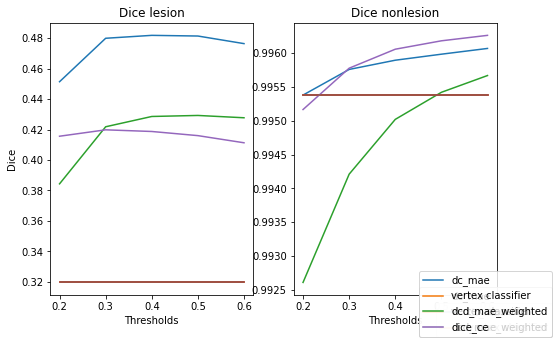

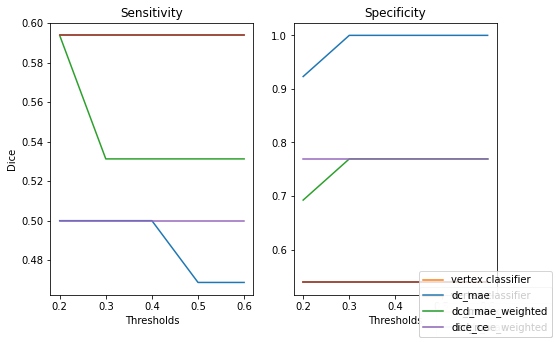

In [66]:
# plot curves dices score at different threshold

import h5py
def load_prediction(subject,hdf5):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi]['prediction'][:]
    return results

from meld_graph.training import tp_fp_fn_tn, get_sensitivity, dice_coeff
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import torch


features=['']
threshes = [0.2,0.3,0.4,0.5,0.6]

c = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')
              
subjects = np.array(df[np.array(list(set(model_base_paths)))[0]]['ID'])

predictions_file_1 = os.path.join('/rds/project/kw350',
             'rds-kw350-meld/experiments',
             'co-ripa1/iteration_21-09-15/ensemble_21-09-15',
             'fold_all/results/',
             'predictions_ensemble_iteration.hdf5')

predictions_file_2 = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')

# fig, ax =plt.subplots(len(model_base_paths.keys()), 2, figsize=(20,30))
fig, ax =plt.subplots(1,2,figsize=(8,5))
fig2, ax2 = plt.subplots(1,2, figsize=(8,5))

for i, model_name in enumerate(model_base_paths.keys()):  
    
    results_file = os.path.join(model_base_paths[model_name], 'results', 'test_results.csv')
    
    predictions_file = os.path.join(model_base_paths[model_name], 'results', 'predictions.hdf5')

    #### compute for multiple threshold with function from training
    stored_scores=[[],[],[],[],[],[]]
    
    for si,subject in enumerate(subjects):
        # print(subject)
        if si%100==0:
            print(si/len(subjects))
            
        results=[]
        try:
            hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                        'iteration_21-09-15/ensemble_21-09-15/fold_all/',
                                        'results','predictions_ensemble_iteration.hdf5')
            result_hemis = load_prediction(subject,hdf_predictions)
            results.append(result_hemis)
        except KeyError:
            hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                        'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                        'results','predictions_ensemble_iteration.hdf5')
            result_hemis = load_prediction(subject,hdf_predictions)
            results.append(result_hemis)
            
        new_result_hemis = load_prediction(subject,predictions_file)
        for t in threshes:
            ti={}
            for hemi in ['lh','rh']:
                ti[hemi]=new_result_hemis[hemi]>t
            
            results.append(ti)           

        labels_hemis = {}
        
        subj = MeldSubject(subject,cohort=c)
        detected = False
        stats_stored = np.zeros((len(results),4))
        dices = np.zeros((len(results),2))

        pred={}
        target={}
        
        for ri,r in enumerate(results):
            for hemi in ['lh','rh']:
                _, label = subj.load_feature_lesion_data(
                    features, hemi=hemi, features_to_ignore=[])
                
                pred[hemi] = r[hemi].astype('bool')
                target[hemi] = label[c.cortex_mask]
            
            preds = torch.as_tensor(np.array(np.hstack([pred['lh'], pred['rh']]))).long()
            targets = torch.as_tensor(np.array(np.hstack([target['lh'], target['rh']]))).long()
            stats_stored[ri]=tp_fp_fn_tn(preds, targets)
            dices[ri] = dice_coeff(torch.nn.functional.one_hot(preds, num_classes=2),targets)
        
        for ri,r in enumerate(results):
            stored_scores[ri].append([subject,subj.is_patient])
            stored_scores[ri][-1].extend(list(stats_stored[ri]))
            stored_scores[ri][-1].extend(list(dices[ri]))


    # compute mean dices for cohort
    patient_only = (np.array(stored_scores)[0,:,1]=='True')
    stored_dices_array = (np.array(stored_scores)[:,:,7]).astype('float').mean(axis=1)
    stored_nondices_array = (np.array(stored_scores)[:,:,6]).astype('float').mean(axis=1)

    # compute sensitivity and specificity
    stored_sensitivity_array = (np.array(stored_scores)[:,patient_only,2].astype('float')>0).sum(axis=1)/patient_only.sum()
    stored_specificity_array = (np.array(stored_scores)[:,~patient_only,3].astype('float')==0.0).sum(axis=1)/(~patient_only).sum()

    
    ax[0].plot(threshes,stored_dices_array[1:], label=model_name)
    if i==0:
        ax[0].plot([threshes[0],threshes[-1]],[stored_dices_array[0],stored_dices_array[0]],label='vertex classifier')
    else:
        ax[0].plot([threshes[0],threshes[-1]],[stored_dices_array[0],stored_dices_array[0]])
    ax[0].set_xlabel('Thresholds')
    ax[0].set_ylabel('Dice')
    ax[0].set_title("Dice lesion")
    #,stored_nondice
    ax[1].plot(threshes,stored_nondices_array[1:])
    ax[1].plot([threshes[0],threshes[-1]],[stored_nondices_array[0],stored_nondices_array[0]])
    #,stored_nondice
    ax[1].set_xlabel('Thresholds')
    ax[1].set_title("Dice nonlesion")
    fig.legend(loc='lower right')

    ax2[0].plot(threshes,stored_sensitivity_array[1:],)
    if i==0:
        ax2[0].plot([threshes[0],threshes[-1]],[stored_sensitivity_array[0],stored_sensitivity_array[0]],label='vertex classifier')
    else:
        ax2[0].plot([threshes[0],threshes[-1]],[stored_sensitivity_array[0],stored_sensitivity_array[0]])
    ax2[0].set_xlabel('Thresholds')
    ax2[0].set_ylabel('Dice')

    ax2[0].set_title("Sensitivity")
    #,stored_nondice
    ax2[1].plot(threshes,stored_specificity_array[1:], label=model_name)
    ax2[1].plot([threshes[0],threshes[-1]],[stored_specificity_array[0],stored_specificity_array[0]])
    #,stored_nondice
    ax2[1].set_xlabel('Thresholds')
    ax2[1].set_title("Specificity")
    fig2.legend(loc='lower right')

MELD_H17_3T_FCD_0092


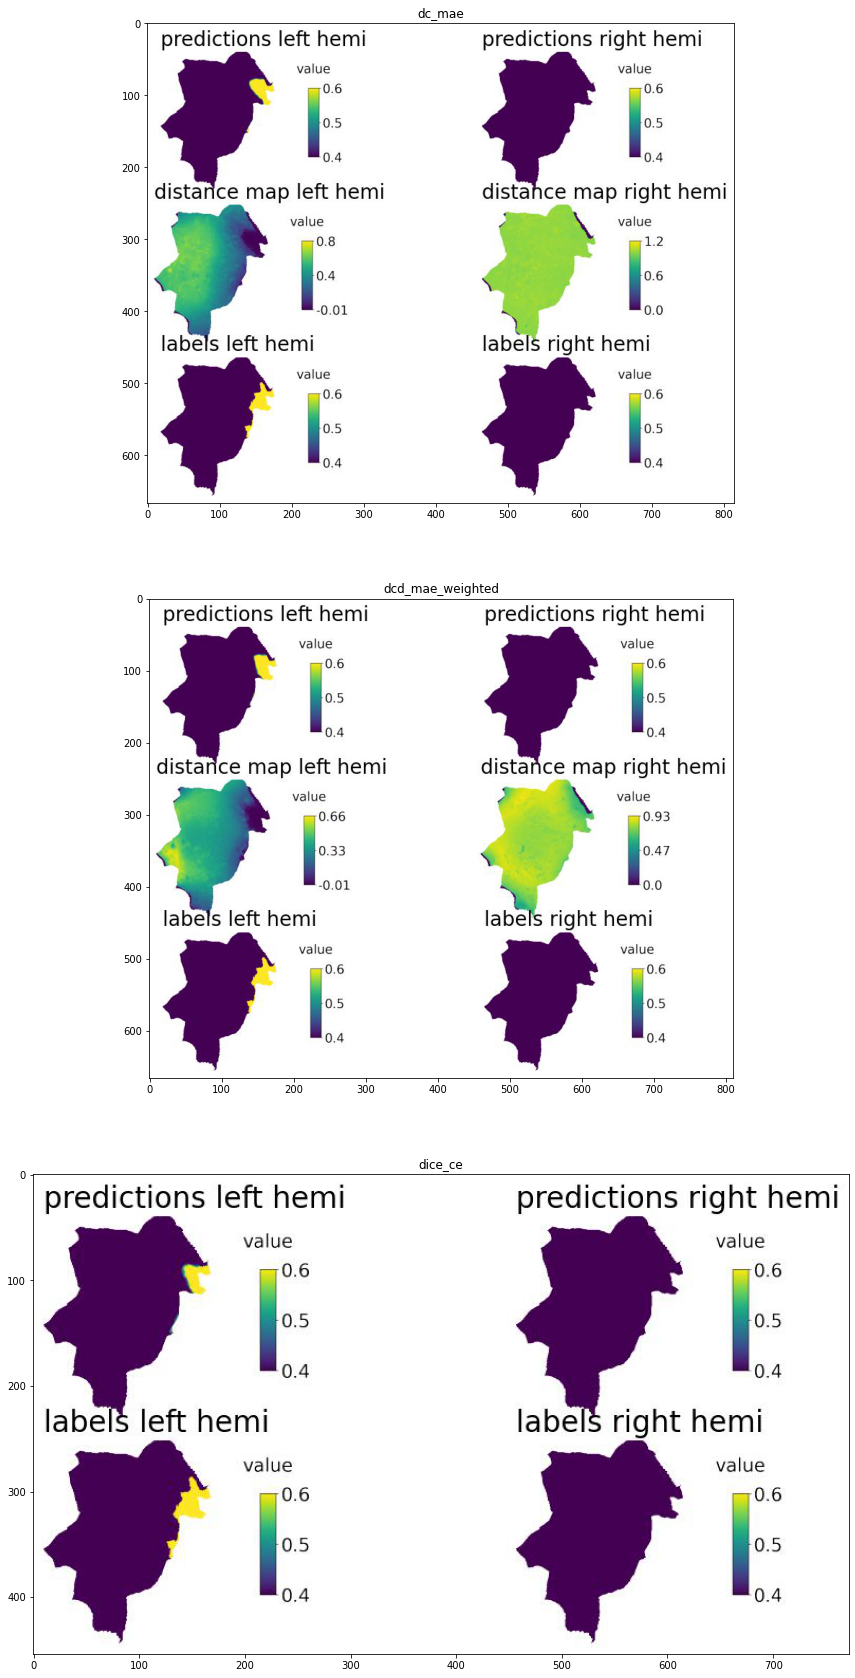

In [61]:
## compare images for 1 subject

subject = subjects[0]
print(subject)

fig, axs = plt.subplots(len(model_base_paths.keys()), 1, figsize=(20,30))

for i, model_name in enumerate(model_base_paths.keys()):  
    
    image_file = os.path.join(model_base_paths[model_name], 'results','images', f'{subject}.jpg')
    im = plt.imread(image_file)
    axs[i].imshow(im)
    axs[i].set_title(model_name)